# Virus Image Classification

## Set up Images File Structure and Get the Data

In [ ]:
from pathlib import Path

data_path = Path('data/')
image_path = data_path / 'Covid19-dataset'
if image_path.is_dir():
  print("Directory already created")
else:
  image_path.mkdir(parents=True, exist_ok=True)

In [ ]:
from pathlib import Path
data_path = Path('data')
image_path = data_path / 'Covid19-dataset'
from zipfile import ZipFile
#with ZipFile(data_path / "Covid19-dataset.zip", "r") as zip_ref:
  zip_ref.extractall(image_path)

In [ ]:
from zipfile import ZipFile

with ZipFile(data_path / "Covid19-dataset.zip", "r") as zip_ref:
  zip_ref.extractall(image_path)

In [ ]:
data_path

In [ ]:
data_path / 'Covid19-dataset.zip'

PosixPath('data/Covid19-dataset.zip')

## Visualize the Image

Covid


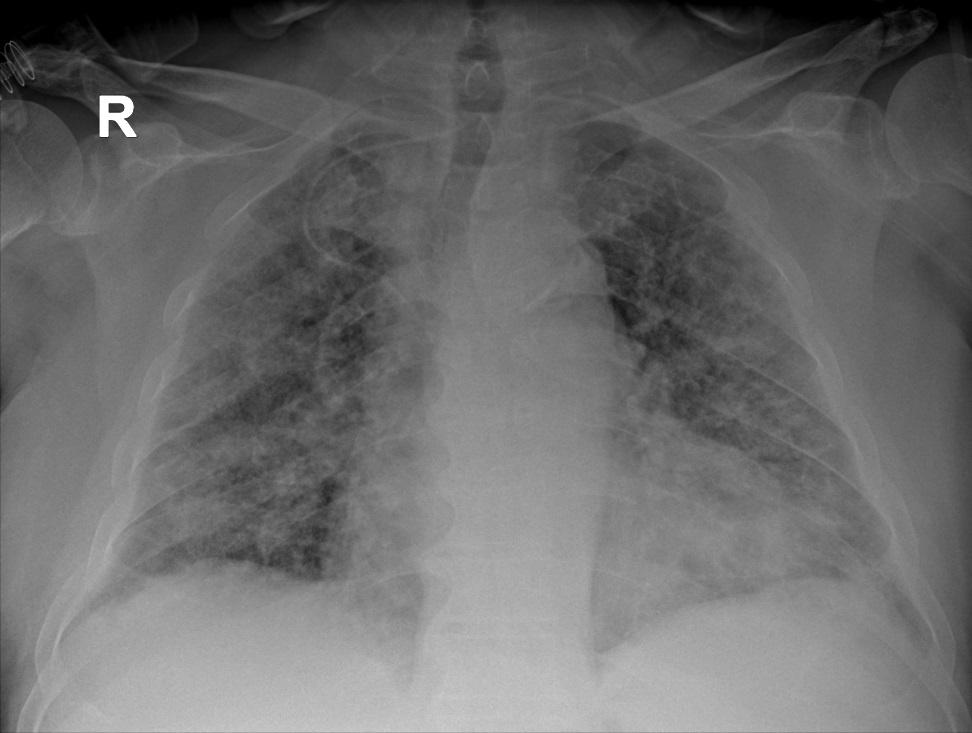

In [ ]:
import random
from PIL import Image
img = random.choice(list(image_path.glob("*/*/*/*.jpg")))
img_class = img.parent.stem
print(img_class)
random_img = Image.open(img)
random_img

## Converting Images to Tensors 

In [ ]:
from torchvision import transforms
# try 128 x 128 or 256 x 256
torch_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

## Setting up PyTorch Image Folders and Train and Test Data Loaders

In [ ]:
train_path = image_path / 'Covid19-dataset' / 'train'
test_path = image_path / 'Covid19-dataset' / 'test'

from torchvision.datasets import ImageFolder

train_dir = ImageFolder(root=train_path, transform=torch_transform, target_transform=None)
test_dir = ImageFolder(root=test_path, transform=torch_transform)

In [ ]:
from torch.utils.data import DataLoader

train_data = DataLoader(train_dir, batch_size=32, shuffle=True)
test_data = DataLoader(test_dir, batch_size=32, shuffle=False)

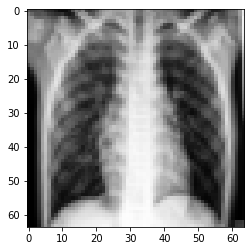

In [ ]:
image_features, image_labels = next(iter(train_data))
import matplotlib.pyplot as plt
plt.imshow(image_features[0].permute(1, 2, 0))

In [ ]:
image_features.shape

torch.Size([32, 3, 64, 64])

## Setting up Base CNN Model 

In [ ]:
from torch import nn
class VirusCNNModelV0(nn.Module):
  def __init__(self, input_features, hidden_features, output_features):
    super().__init__()
    self.conv_layer_1 = nn.Sequential(
        nn.Conv2d(in_channels = input_features, out_channels=hidden_features, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_features, out_channels=hidden_features,kernel_size=3,stride=1,padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,stride=2)
    )
    self.conv_layer_2 = nn.Sequential(nn.Conv2d(in_channels = hidden_features, out_channels=hidden_features, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_features, out_channels=hidden_features,kernel_size=3,stride=1,padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_features, out_channels=hidden_features,kernel_size=3,stride=1,padding=1),
        nn.MaxPool2d(kernel_size=2,stride=2))
    self.classifier_layer = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_features*16*16, out_features=output_features)
    )
  def forward(self, x):
    x = self.conv_layer_1(x)
    print(f"Shape after first Layer: {x.shape}")
    x = self.conv_layer_2(x)
    print(f"Shape after second Layer: {x.shape}")
    x = self.classifier_layer(x)
    return x
model_0 = VirusCNNModelV0(input_features=3, hidden_features=10, output_features=len(train_dir.classes))

In [ ]:
def train_step(model, train_data, loss_fn, optimizer):

  train_loss, train_acc = 0, 0
  for batch, (X, y) in enumerate(train_data):
      model.train()

      y_pred = model(X)

      # Calculate the loss
      loss = loss_fn(y_pred, y)
      train_loss += loss.item()

      # Calculate the accuracy
      acc = torch.argmax(torch.softmax(y_pred, dim = 1), dim = 1)
      train_acc += (acc==y).sum().item()/len(y_pred)

      optimizer.zero_grad()

      loss.backward()

      optimizer.step()

  train_loss /= len(train_data)
  train_acc /= len(train_data)

  return train_loss, train_acc

In [ ]:
import torch

def test_step(model, test_data, loss_fn):
  model.eval()
  test_acc, test_loss = 0, 0
  with torch.inference_mode():
    for batch, (X_test, y_test) in enumerate(test_data):
      y_pred_test = model(X_test)

      loss = loss_fn(y_pred_test, y_test)
      test_loss += loss.item()

      acc = torch.argmax(y_pred_test, dim = 1)
      test_acc += (acc == y_test).sum().item()/len(y_pred_test)

    test_loss /= len(test_data)
    test_acc /= len(test_data)

  return test_loss, test_acc

## Training the Model and Evaluating the Model

In [ ]:
def train_model(model, epochs):
  epochs = 5
  loss_fn = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

  for epoch in range(epochs):
    train_loss, train_acc = train_step(model, train_data, loss_fn, optimizer)
    test_loss, test_acc = test_step(model, test_data, loss_fn)

    print(f"Training accuracy: {train_acc} | Training Loss: {train_loss} | Testing accuracy: {test_acc} | Testing loss {test_loss}")
  results_dict = {
      'train_acc': train_acc,
      'train_loss': train_loss,
      'test_acc': test_acc,
      'test_loss': test_loss
  }
  return results_dict

model_results = train_model(model_0, 5)
model_results

Shape after first Layer: torch.Size([32, 10, 32, 32])
Shape after second Layer: torch.Size([32, 10, 16, 16])
Shape after first Layer: torch.Size([32, 10, 32, 32])
Shape after second Layer: torch.Size([32, 10, 16, 16])
Shape after first Layer: torch.Size([32, 10, 32, 32])
Shape after second Layer: torch.Size([32, 10, 16, 16])
Shape after first Layer: torch.Size([32, 10, 32, 32])
Shape after second Layer: torch.Size([32, 10, 16, 16])
Shape after first Layer: torch.Size([32, 10, 32, 32])
Shape after second Layer: torch.Size([32, 10, 16, 16])
Shape after first Layer: torch.Size([32, 10, 32, 32])
Shape after second Layer: torch.Size([32, 10, 16, 16])
Shape after first Layer: torch.Size([32, 10, 32, 32])
Shape after second Layer: torch.Size([32, 10, 16, 16])
Shape after first Layer: torch.Size([27, 10, 32, 32])
Shape after second Layer: torch.Size([27, 10, 16, 16])
Shape after first Layer: torch.Size([32, 10, 32, 32])
Shape after second Layer: torch.Size([32, 10, 16, 16])
Shape after first L

{'train_acc': 0.9033564814814815,
 'train_loss': 0.31064524967223406,
 'test_acc': 0.84375,
 'test_loss': 0.4693988561630249}

## Using the Model to Predict on Custom Image

In [ ]:
import os
import torchvision
custom_image_path = image_path / 'Covid19-dataset' / 'train' / 'Viral Pneumonia' 
random_pic = random.choice(os.listdir(custom_image_path))
pic = torchvision.io.read_image(str(custom_image_path / random_pic)).type(torch.float32)
pic = pic / 255


(-0.5, 1359.5, 919.5, -0.5)

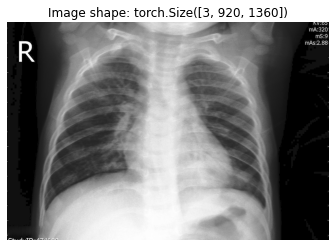

In [ ]:
plt.imshow(pic.permute(1, 2, 0))
plt.title(f"Image shape: {pic.shape}")
plt.axis(False)

In [ ]:
transformed_img = transforms.Compose([
    transforms.Resize((64, 64))
])
custom_image_transformed = transformed_img(pic)
model_0.eval()
with torch.inference_mode():
  custom_image_batched = custom_image_transformed.unsqueeze(dim=0)

  custom_image_pred = model_0(custom_image_transformed.unsqueeze(dim=0))


Shape after first Layer: torch.Size([1, 10, 32, 32])
Shape after second Layer: torch.Size([1, 10, 16, 16])


In [ ]:
custom_image_pred

tensor([[-3.5461, -0.4535,  3.5639]])

In [ ]:
custom_image_pred_prob = torch.softmax(custom_image_pred, dim=1)

custom_image_pred_label = torch.argmax(custom_image_pred_prob, dim = 1)


In [ ]:
custom_image_pred_class = train_dir.classes[custom_image_pred_label.cpu()]

In [ ]:
custom_image_pred_class

'Viral Pneumonia'